### Importing relevant libraries

In [1]:
!pip install transformers
!pip install evaluate
!pip install transforms

!pip install "ray[tune]" scipy sklearn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json
import glob 
import itertools
from PIL import Image
from transformers import (
    AutoImageProcessor, 
    ViTForImageClassification, 
    SwinForImageClassification,
    TrainingArguments, 
    Trainer,
    ResNetModel,
    AutoTokenizer, 
    BertModel,
    BertPreTrainedModel,
    DefaultDataCollator,
    ViTFeatureExtractor,
    ViTMAEForPreTraining,
    ViTMAEConfig,
    ViTImageProcessor
)
from tqdm.auto import tqdm
from transformers.modeling_outputs import SequenceClassifierOutput
import evaluate
from datasets import load_dataset
import requests
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
# import scikitplot as skplt
import pandas as pd
from transformers import pipeline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Training helper functions

In [2]:
# A function to see the size and # of params of a model - taken from class examples
def get_model_info(model):
    # Compute number of trainable parameters in the model
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Compute the size of the model in MB
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
        
    size_all_mb = (param_size + buffer_size) / 1024**2
    
    return num_params, size_all_mb

# Data collator - form a batch by using a list of dataset elements as input
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

### Visualizing output from pretrained ViTMAE

In [2]:
# from https://github.com/NielsRogge/Transformers-Tutorials/blob/master/ViTMAE/ViT_MAE_visualization_demo.ipynb

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")
imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    converted_img = torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int()
    plt.imshow(converted_img)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return 

def visualize_single_image(pixel_values):
    x = torch.einsum('nchw->nhwc', pixel_values)
    show_image(x[0], "original")

def visualize(pixel_values, model):
    # forward pass
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)

model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

#### Specific image example
url = "https://datasets-server.huggingface.co/assets/keremberke/chest-xray-classification/--/full/train/2/image/image.jpg"
image = Image.open(requests.get(url, stream=True).raw)
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
visualize(pixel_values, model)

NameError: ignored

### Dataset preprocessing

In [15]:
cudnn.benchmark = True
plt.ion()   # interactive mode
nih_dataset = False
model_name_or_path = (
    "facebook/vit-mae-base"
)
data_dir_name = "./vit-finetune"

# loading dataset
if nih_dataset:
  ds = load_dataset("alkzar90/NIH-Chest-X-ray-dataset", name="image-classification")
  labels = ds["train"].features["labels"].feature.names #nih dataset
  test_ds = "test"
else:
  ds = load_dataset("keremberke/chest-xray-classification", name="full")
  labels = ds["train"].features["labels"].names #chest xray dataset
  test_ds = "validation"
ds = ds.with_format("torch")

#loading image_processor
image_processor = ViTImageProcessor.from_pretrained(model_name_or_path, padding=True) #gives normalize func error

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# defining a custom weighted loss for my imbalanced dataset - see https://huggingface.co/docs/transformers/main_classes/trainer?highlight=trainer#trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")

        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (data biases positive label, weight 0 label more)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([2.0, 1.0]).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#defining transforms
size = (
    image_processor.size["shortest_edge"] if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
normalize = transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

# includes data augmentation
train_transforms = transforms.Compose(
        [
            transforms.RandomResizedCrop(size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]
    )

#no data augmentation
val_transforms = transforms.Compose(
        [
            transforms.Resize(size),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

ds['train'].set_transform(preprocess_train)
ds['validation'].set_transform(preprocess_val)

  0%|          | 0/3 [00:00<?, ?it/s]

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--facebook--vit-mae-base/snapshots/87dd4faac12498cde93a176406329112584c0413/preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



### Hyperparameter search with Ray Tune

In [6]:
!pip install ray[tune]
from ray import tune
from ray.tune import CLIReporter, ResultGrid
from ray.tune.examples.pbt_transformers.utils import (
    download_data,
    build_compute_metrics_fn,
)
from ray.tune.schedulers import PopulationBasedTraining
from tqdm.auto import tqdm
from transformers import (
    AutoConfig
)

smoke_test = False
samples = 20
gpus_per_trial = 1

task_name = "rte"
task_data_dir = data_dir_name+"-"+task_name
num_labels = len(labels)

# init config object
config = AutoConfig.from_pretrained(
    model_name_or_path, num_labels=num_labels, finetuning_task=task_name
)

# Triggers pre-trained model download to cache
ViTForImageClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

# define model initialization function for trainer
def model_init():
    model = ViTForImageClassification.from_pretrained(
        model_name_or_path,
        config=config,
    )
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    
    # Freeze the entire model:
    for p in model.parameters():
      p.requires_grad = False
    
    # Turn back on the classifier weights
    for p in model.classifier.parameters():
      p.requires_grad=True  

    return model

# define training arguments
training_args = TrainingArguments(
  output_dir=task_data_dir,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=32,
  evaluation_strategy="epoch", 
  num_train_epochs=4,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=1e-5,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  # report_to='tensorboard',
  load_best_model_at_end=True,
  do_train=True,
  do_eval=True,
  # max_steps=-1,
  weight_decay=0.1,
  logging_dir="./logs",
  skip_memory_metrics=True,
  report_to="none",

  #from class
  save_strategy="epoch",
  lr_scheduler_type="cosine",
  dataloader_num_workers=0,
)

# create tune config object
tune_config = {
    "per_device_train_batch_size": 16,
    "per_device_eval_batch_size": 16,
    "num_train_epochs": tune.choice([2, 3, 4]),
    "max_steps": 1 if smoke_test else -1,  # Used for smoke test.
}

# initialize scheduler with args
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    metric="eval_acc",
    mode="max",
    perturbation_interval=1,
    hyperparam_mutations={
        "weight_decay": tune.uniform(0.0, 0.3),
        "learning_rate": tune.uniform(1e-5, 5e-5),
        "per_device_train_batch_size": tune.choice([8, 16, 32]),
        "per_device_eval_batch_size": tune.choice([8, 16, 32]),
        "lr_scheduler_type": tune.choice(["linear", "cosine", "cosine_with_restarts", "polynomial", "constant_with_warmup"]),
    },
)

# initialize report with args, define what info what will be reported
reporter = CLIReporter(
    parameter_columns={
        "weight_decay": "w_decay",
        "learning_rate": "lr",
        "per_device_train_batch_size": "train_bs/gpu",
        "num_train_epochs": "num_epochs",
        "lr_scheduler_type": "lr_scheduler",
    },
    metric_columns=["eval_acc", "eval_loss", "epoch", "training_iteration"],
)

# Create the trainer
trainer = Trainer(
    model=None,
    model_init=model_init,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=build_compute_metrics_fn(task_name),
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    tokenizer=image_processor,
)

# launch hyperparameter search
trainer.hyperparameter_search(
    hp_space=lambda _: tune_config,
    backend="ray",
    n_trials=samples,
    resources_per_trial={"cpu": 1, "gpu": gpus_per_trial},
    scheduler=scheduler,
    keep_checkpoints_num=1,
    checkpoint_score_attr="training_iteration",
    stop={"training_iteration": 1} if smoke_test else None,
    progress_reporter=reporter,
    local_dir="./ray_results/",
    name="tune_transformer_pbt",
    log_to_file=True,
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--vit-mae-base/snapshots/87dd4faac12498cde93a176406329112584c0413/config.json
Model config ViTMAEConfig {
  "_name_or_path": "facebook/vit-mae-base",
  "architectures": [
    "ViTMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 512,
  "decoder_intermediate_size": 2048,
  "decoder_num_attention_heads": 16,
  "decoder_num_hidden_layers": 8,
  "finetuning_task": "rte",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "mask_ratio": 0.75,
  "model_type": "vit_mae",
  "norm_pix_loss": false,
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1"
}

loading weights file pytorch_model.bin from cache at /

== Status ==
Current time: 2023-03-03 00:04:20 (running for 00:00:00.06)
Memory usage on this node: 4.9/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------+
| Trial name             | status   | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |
|------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------|
| _objective_f2586_00000 | RUNNING  | 172.28.0.12:54539 | 0.238963  | 1.73374e-05 |             16 |            4 | constant_with_warmup |
| _objective_f2586_00001 | PENDING  |                   | 0.0468056 | 1.62398e-05 |         

(_objective pid=54539) Some weights of the model checkpoint at facebook/vit-mae-base were not used when initializing ViTForImageClassification: ['decoder.decoder_layers.5.output.dense.weight', 'decoder.decoder_layers.6.intermediate.dense.bias', 'decoder.decoder_layers.4.output.dense.weight', 'decoder.decoder_layers.2.attention.attention.query.bias', 'decoder.decoder_layers.7.intermediate.dense.weight', 'decoder.decoder_layers.0.attention.attention.key.bias', 'decoder.decoder_layers.4.attention.attention.key.weight', 'decoder.decoder_layers.0.layernorm_after.weight', 'decoder.decoder_layers.5.attention.attention.query.bias', 'decoder.decoder_layers.7.attention.attention.query.bias', 'decoder.decoder_layers.7.output.dense.bias', 'decoder.decoder_layers.3.attention.attention.value.weight', 'decoder.decoder_layers.0.layernorm_after.bias', 'decoder.decoder_layers.3.attention.output.dense.bias', 'decoder.decoder_layers.4.layernorm_before.bias', 'decoder.decoder_layers.5.attention.output.dens

== Status ==
Current time: 2023-03-03 00:04:30 (running for 00:00:10.68)
Memory usage on this node: 7.2/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------+
| Trial name             | status   | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |
|------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------|
| _objective_f2586_00000 | RUNNING  | 172.28.0.12:54539 | 0.238963  | 1.73374e-05 |             16 |            4 | constant_with_warmup |
| _objective_f2586_00001 | PENDING  |                   | 0.0468056 | 1.62398e-05 |         

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]
(_objective pid=54539) 
  0%|          | 0/73 [00:00<?, ?it/s]
(_objective pid=54539) 
  3%|▎         | 2/73 [00:00<00:11,  6.43it/s]
(_objective pid=54539) 
  4%|▍         | 3/73 [00:00<00:15,  4.56it/s]
(_objective pid=54539) 
  5%|▌         | 4/73 [00:00<00:17,  3.99it/s]
(_objective pid=54539) 
  7%|▋         | 5/73 [00:01<00:18,  3.73it/s]
(_objective pid=54539) 
  8%|▊         | 6/73 [00:01<00:18,  3.60it/s]
(_objective pid=54539) 
 10%|▉         | 7/73 [00:01<00:18,  3.49it/s]
(_objective pid=54539) 
 11%|█         | 8/73 [00:02<00:18,  3.43it/s]
(_objective pid=54539) 
 12%|█▏        | 9/73 [00:02<00:18,  3.37it/s]
(_objective pid=54539) 
 14%|█▎        | 10/73 [00:02<00:18,  3.34it/s]
(_objective pid=54539) 
 15%|█▌        | 11/73 [00:03<00:18,  3.35it/s]


== Status ==
Current time: 2023-03-03 00:04:35 (running for 00:00:15.69)
Memory usage on this node: 7.7/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------+
| Trial name             | status   | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |
|------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------|
| _objective_f2586_00000 | RUNNING  | 172.28.0.12:54539 | 0.238963  | 1.73374e-05 |             16 |            4 | constant_with_warmup |
| _objective_f2586_00001 | PENDING  |                   | 0.0468056 | 1.62398e-05 |         

(_objective pid=54539) 
 16%|█▋        | 12/73 [00:03<00:18,  3.33it/s]
(_objective pid=54539) 
 18%|█▊        | 13/73 [00:03<00:18,  3.32it/s]
(_objective pid=54539) 
 19%|█▉        | 14/73 [00:03<00:17,  3.33it/s]
(_objective pid=54539) 
 21%|██        | 15/73 [00:04<00:17,  3.32it/s]
(_objective pid=54539) 
 22%|██▏       | 16/73 [00:04<00:17,  3.34it/s]
(_objective pid=54539) 
 23%|██▎       | 17/73 [00:04<00:16,  3.33it/s]
(_objective pid=54539) 
 25%|██▍       | 18/73 [00:05<00:16,  3.30it/s]
(_objective pid=54539) 
 26%|██▌       | 19/73 [00:05<00:16,  3.29it/s]
(_objective pid=54539) 
 27%|██▋       | 20/73 [00:05<00:16,  3.28it/s]
(_objective pid=54539) 
 29%|██▉       | 21/73 [00:06<00:16,  3.19it/s]
(_objective pid=54539) 
 30%|███       | 22/73 [00:06<00:18,  2.73it/s]
(_objective pid=54539) 
 32%|███▏      | 23/73 [00:07<00:30,  1.62it/s]


== Status ==
Current time: 2023-03-03 00:04:40 (running for 00:00:20.70)
Memory usage on this node: 7.8/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------+
| Trial name             | status   | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |
|------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------|
| _objective_f2586_00000 | RUNNING  | 172.28.0.12:54539 | 0.238963  | 1.73374e-05 |             16 |            4 | constant_with_warmup |
| _objective_f2586_00001 | PENDING  |                   | 0.0468056 | 1.62398e-05 |         

(_objective pid=54539) 
 33%|███▎      | 24/73 [00:11<01:09,  1.42s/it]
(_objective pid=54539) 
 34%|███▍      | 25/73 [00:12<01:11,  1.49s/it]


== Status ==
Current time: 2023-03-03 00:04:45 (running for 00:00:25.72)
Memory usage on this node: 7.9/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------+
| Trial name             | status   | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |
|------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------|
| _objective_f2586_00000 | RUNNING  | 172.28.0.12:54539 | 0.238963  | 1.73374e-05 |             16 |            4 | constant_with_warmup |
| _objective_f2586_00001 | PENDING  |                   | 0.0468056 | 1.62398e-05 |         

(_objective pid=54539) 
 36%|███▌      | 26/73 [00:14<01:08,  1.45s/it]
(_objective pid=54539) 
 37%|███▋      | 27/73 [00:15<01:03,  1.38s/it]
(_objective pid=54539) 
 38%|███▊      | 28/73 [00:15<00:48,  1.09s/it]
(_objective pid=54539) 
 40%|███▉      | 29/73 [00:16<00:38,  1.13it/s]
(_objective pid=54539) 
 41%|████      | 30/73 [00:16<00:31,  1.36it/s]
(_objective pid=54539) 
 42%|████▏     | 31/73 [00:16<00:26,  1.56it/s]
(_objective pid=54539) 
 44%|████▍     | 32/73 [00:17<00:23,  1.77it/s]
(_objective pid=54539) 
 45%|████▌     | 33/73 [00:17<00:21,  1.90it/s]


== Status ==
Current time: 2023-03-03 00:04:50 (running for 00:00:30.73)
Memory usage on this node: 7.9/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------+
| Trial name             | status   | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |
|------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------|
| _objective_f2586_00000 | RUNNING  | 172.28.0.12:54539 | 0.238963  | 1.73374e-05 |             16 |            4 | constant_with_warmup |
| _objective_f2586_00001 | PENDING  |                   | 0.0468056 | 1.62398e-05 |         

(_objective pid=54539) 
 47%|████▋     | 34/73 [00:18<00:21,  1.82it/s]
(_objective pid=54539) 
 48%|████▊     | 35/73 [00:18<00:20,  1.81it/s]
(_objective pid=54539) 
 49%|████▉     | 36/73 [00:19<00:21,  1.73it/s]
(_objective pid=54539) 
 51%|█████     | 37/73 [00:20<00:19,  1.86it/s]
(_objective pid=54539) 
 52%|█████▏    | 38/73 [00:20<00:17,  1.99it/s]
(_objective pid=54539) 
 53%|█████▎    | 39/73 [00:20<00:17,  1.91it/s]
(_objective pid=54539) 
 55%|█████▍    | 40/73 [00:22<00:28,  1.16it/s]


== Status ==
Current time: 2023-03-03 00:04:56 (running for 00:00:35.74)
Memory usage on this node: 8.0/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------+
| Trial name             | status   | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |
|------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------|
| _objective_f2586_00000 | RUNNING  | 172.28.0.12:54539 | 0.238963  | 1.73374e-05 |             16 |            4 | constant_with_warmup |
| _objective_f2586_00001 | PENDING  |                   | 0.0468056 | 1.62398e-05 |         

(_objective pid=54539) 
 56%|█████▌    | 41/73 [00:25<00:45,  1.43s/it]
(_objective pid=54539) 
 58%|█████▊    | 42/73 [00:27<00:49,  1.61s/it]


== Status ==
Current time: 2023-03-03 00:05:01 (running for 00:00:40.76)
Memory usage on this node: 8.1/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------+
| Trial name             | status   | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |
|------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------|
| _objective_f2586_00000 | RUNNING  | 172.28.0.12:54539 | 0.238963  | 1.73374e-05 |             16 |            4 | constant_with_warmup |
| _objective_f2586_00001 | PENDING  |                   | 0.0468056 | 1.62398e-05 |         

(_objective pid=54539) 
 59%|█████▉    | 43/73 [00:30<00:58,  1.94s/it]
(_objective pid=54539) 
 60%|██████    | 44/73 [00:31<00:50,  1.75s/it]
(_objective pid=54539) 
 62%|██████▏   | 45/73 [00:32<00:42,  1.53s/it]


== Status ==
Current time: 2023-03-03 00:05:06 (running for 00:00:45.78)
Memory usage on this node: 8.1/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------+
| Trial name             | status   | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |
|------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------|
| _objective_f2586_00000 | RUNNING  | 172.28.0.12:54539 | 0.238963  | 1.73374e-05 |             16 |            4 | constant_with_warmup |
| _objective_f2586_00001 | PENDING  |                   | 0.0468056 | 1.62398e-05 |         

(_objective pid=54539) 
 63%|██████▎   | 46/73 [00:33<00:40,  1.51s/it]
(_objective pid=54539) 
 64%|██████▍   | 47/73 [00:35<00:37,  1.43s/it]
(_objective pid=54539) 
 66%|██████▌   | 48/73 [00:35<00:29,  1.16s/it]
(_objective pid=54539) 
 67%|██████▋   | 49/73 [00:36<00:26,  1.11s/it]
(_objective pid=54539) 
 68%|██████▊   | 50/73 [00:37<00:20,  1.13it/s]
(_objective pid=54539) 
 70%|██████▉   | 51/73 [00:37<00:17,  1.23it/s]
(_objective pid=54539) 
 71%|███████   | 52/73 [00:38<00:15,  1.34it/s]


== Status ==
Current time: 2023-03-03 00:05:11 (running for 00:00:50.79)
Memory usage on this node: 8.1/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------+
| Trial name             | status   | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |
|------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------|
| _objective_f2586_00000 | RUNNING  | 172.28.0.12:54539 | 0.238963  | 1.73374e-05 |             16 |            4 | constant_with_warmup |
| _objective_f2586_00001 | PENDING  |                   | 0.0468056 | 1.62398e-05 |         

(_objective pid=54539) 
 73%|███████▎  | 53/73 [00:38<00:13,  1.45it/s]
(_objective pid=54539) 
 74%|███████▍  | 54/73 [00:39<00:12,  1.58it/s]
(_objective pid=54539) 
 75%|███████▌  | 55/73 [00:39<00:10,  1.71it/s]
(_objective pid=54539) 
 77%|███████▋  | 56/73 [00:40<00:08,  1.90it/s]
(_objective pid=54539) 
 78%|███████▊  | 57/73 [00:40<00:07,  2.03it/s]
(_objective pid=54539) 
 79%|███████▉  | 58/73 [00:41<00:07,  2.11it/s]
(_objective pid=54539) 
 81%|████████  | 59/73 [00:41<00:06,  2.23it/s]
(_objective pid=54539) 
 82%|████████▏ | 60/73 [00:41<00:05,  2.26it/s]
(_objective pid=54539) 
 84%|████████▎ | 61/73 [00:42<00:05,  2.34it/s]
(_objective pid=54539) 
 85%|████████▍ | 62/73 [00:42<00:04,  2.36it/s]
(_objective pid=54539) 
 86%|████████▋ | 63/73 [00:43<00:04,  2.38it/s]


== Status ==
Current time: 2023-03-03 00:05:16 (running for 00:00:55.79)
Memory usage on this node: 8.1/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------+
| Trial name             | status   | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |
|------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------|
| _objective_f2586_00000 | RUNNING  | 172.28.0.12:54539 | 0.238963  | 1.73374e-05 |             16 |            4 | constant_with_warmup |
| _objective_f2586_00001 | PENDING  |                   | 0.0468056 | 1.62398e-05 |         

(_objective pid=54539) 
 88%|████████▊ | 64/73 [00:43<00:03,  2.41it/s]
(_objective pid=54539) 
 89%|████████▉ | 65/73 [00:43<00:03,  2.39it/s]
(_objective pid=54539) 
 90%|█████████ | 66/73 [00:44<00:02,  2.39it/s]
(_objective pid=54539) 
 92%|█████████▏| 67/73 [00:44<00:02,  2.43it/s]
(_objective pid=54539) 
 93%|█████████▎| 68/73 [00:45<00:02,  2.17it/s]
(_objective pid=54539) 
 95%|█████████▍| 69/73 [00:45<00:01,  2.25it/s]
(_objective pid=54539) 
 96%|█████████▌| 70/73 [00:46<00:01,  2.31it/s]
(_objective pid=54539) 
 97%|█████████▋| 71/73 [00:46<00:00,  2.37it/s]
(_objective pid=54539) 
 99%|█████████▊| 72/73 [00:46<00:00,  2.41it/s]


(_objective pid=54539) {'eval_loss': 0.5884165167808533, 'eval_acc': 0.7390557939914163, 'eval_runtime': 47.6015, 'eval_samples_per_second': 24.474, 'eval_steps_per_second': 1.534, 'epoch': 0.0}


(_objective pid=54539) 
100%|██████████| 73/73 [00:47<00:00,  2.56it/s]/usr/local/lib/python3.8/dist-packages/transformers/data/metrics/__init__.py:66: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
(_objective pid=54539)   warnings.warn(DEPRECATION_WARNING, FutureWarning)
(_objective pid=54539) /usr/local/lib/python3.8/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
(_objective pid=54539)   warnings.warn(DEPRECATION_WARNING, FutureWarning)
                                

== Status ==
Current time: 2023-03-03 00:05:21 (running for 00:01:00.80)
Memory usage on this node: 8.1/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 PENDING, 1 RUNNING)
+------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------+
| Trial name             | status   | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |
|------------------------+----------+-------------------+-----------+-------------+----------------+--------------+----------------------|
| _objective_f2586_00000 | RUNNING  | 172.28.0.12:54539 | 0.238963  | 1.73374e-05 |             16 |            4 | constant_with_warmup |
| _objective_f2586_00001 | PENDING  |                   | 0.0468056 | 1.62398e-05 |         

Trial name,date,done,episodes_total,epoch,eval_acc,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,experiment_id,hostname,iterations_since_restore,node_ip,objective,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
_objective_f2586_00000,2023-03-03_00-05-21,True,,0,0.739056,0.588417,47.6015,24.474,1.534,eb2239ffefa84dd8aa2856d62acdd7fd,6aaec9d49238,1,172.28.0.12,0.739056,54539,True,55.1593,55.1593,55.1593,1677801921,0,,1,f2586_00000,0.00543475
_objective_f2586_00001,2023-03-03_00-05-59,True,,0,0.739056,0.588431,25.4363,45.801,2.87,864035dd5aac4134b63c3b9143a9b423,6aaec9d49238,1,172.28.0.12,0.739056,54938,True,32.0362,32.0362,32.0362,1677801959,0,,1,f2586_00001,0.00415301


100%|██████████| 1/1 [00:50<00:00, 50.51s/it]
(pid=54938) 2023-03-03 00:05:25.433162: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=54938) 2023-03-03 00:05:25.433267: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
(pid=54938) 2023-03-03 00:05:25.433281: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


== Status ==
Current time: 2023-03-03 00:05:27 (running for 00:01:06.83)
Memory usage on this node: 5.6/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------+
| Trial name             | status     | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |   eval_acc |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------|
| _objective_f2586_00001 | RUNNING    | 17

(_objective pid=54938) Some weights of the model checkpoint at facebook/vit-mae-base were not used when initializing ViTForImageClassification: ['decoder.decoder_layers.2.attention.output.dense.bias', 'decoder.decoder_layers.6.intermediate.dense.weight', 'decoder.decoder_layers.5.layernorm_before.weight', 'decoder.decoder_layers.2.attention.attention.query.weight', 'decoder.decoder_layers.3.intermediate.dense.weight', 'decoder.decoder_layers.5.output.dense.weight', 'decoder.decoder_layers.3.attention.attention.value.bias', 'decoder.decoder_layers.0.layernorm_before.weight', 'decoder.decoder_layers.7.layernorm_after.bias', 'decoder.decoder_layers.4.attention.attention.query.weight', 'decoder.decoder_layers.4.layernorm_after.bias', 'decoder.decoder_layers.0.output.dense.weight', 'decoder.decoder_layers.7.attention.attention.query.weight', 'decoder.decoder_layers.1.intermediate.dense.weight', 'decoder.decoder_layers.2.layernorm_before.bias', 'decoder.decoder_layers.2.attention.attention.k

== Status ==
Current time: 2023-03-03 00:05:32 (running for 00:01:12.49)
Memory usage on this node: 7.8/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------+
| Trial name             | status     | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |   eval_acc |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------|
| _objective_f2586_00001 | RUNNING    | 17

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]
(_objective pid=54938) 
  0%|          | 0/73 [00:00<?, ?it/s]
(_objective pid=54938) 
  3%|▎         | 2/73 [00:00<00:10,  6.57it/s]
(_objective pid=54938) 
  4%|▍         | 3/73 [00:00<00:15,  4.65it/s]
(_objective pid=54938) 
  5%|▌         | 4/73 [00:00<00:17,  3.98it/s]
(_objective pid=54938) 
  7%|▋         | 5/73 [00:01<00:20,  3.29it/s]
(_objective pid=54938) 
  8%|▊         | 6/73 [00:01<00:22,  2.97it/s]
(_objective pid=54938) 
 10%|▉         | 7/73 [00:02<00:23,  2.76it/s]
(_objective pid=54938) 
 11%|█         | 8/73 [00:02<00:24,  2.66it/s]
(_objective pid=54938) 
 12%|█▏        | 9/73 [00:02<00:24,  2.62it/s]
(_objective pid=54938) 
 14%|█▎        | 10/73 [00:03<00:23,  2.68it/s]
(_objective pid=54938) 
 15%|█▌        | 11/73 [00:03<00:23,  2.63it/s]
(_objective pid=54938) 
 16%|█▋        | 12/73 [00:04<00:23,  2.60it/s]


== Status ==
Current time: 2023-03-03 00:05:37 (running for 00:01:17.50)
Memory usage on this node: 8.1/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------+
| Trial name             | status     | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |   eval_acc |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------|
| _objective_f2586_00001 | RUNNING    | 17

(_objective pid=54938) 
 18%|█▊        | 13/73 [00:04<00:23,  2.61it/s]
(_objective pid=54938) 
 19%|█▉        | 14/73 [00:04<00:22,  2.64it/s]
(_objective pid=54938) 
 21%|██        | 15/73 [00:05<00:21,  2.64it/s]
(_objective pid=54938) 
 22%|██▏       | 16/73 [00:05<00:21,  2.64it/s]
(_objective pid=54938) 
 23%|██▎       | 17/73 [00:05<00:21,  2.64it/s]
(_objective pid=54938) 
 25%|██▍       | 18/73 [00:06<00:20,  2.65it/s]
(_objective pid=54938) 
 26%|██▌       | 19/73 [00:06<00:20,  2.64it/s]
(_objective pid=54938) 
 27%|██▋       | 20/73 [00:07<00:19,  2.66it/s]
(_objective pid=54938) 
 29%|██▉       | 21/73 [00:07<00:18,  2.83it/s]
(_objective pid=54938) 
 30%|███       | 22/73 [00:07<00:17,  2.91it/s]
(_objective pid=54938) 
 32%|███▏      | 23/73 [00:08<00:16,  3.04it/s]
(_objective pid=54938) 
 33%|███▎      | 24/73 [00:08<00:15,  3.12it/s]


== Status ==
Current time: 2023-03-03 00:05:42 (running for 00:01:22.51)
Memory usage on this node: 8.1/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------+
| Trial name             | status     | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |   eval_acc |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------|
| _objective_f2586_00001 | RUNNING    | 17

(_objective pid=54938) 
 34%|███▍      | 25/73 [00:09<00:25,  1.86it/s]
(_objective pid=54938) 
 36%|███▌      | 26/73 [00:09<00:22,  2.12it/s]
(_objective pid=54938) 
 37%|███▋      | 27/73 [00:09<00:19,  2.38it/s]
(_objective pid=54938) 
 38%|███▊      | 28/73 [00:10<00:17,  2.62it/s]
(_objective pid=54938) 
 40%|███▉      | 29/73 [00:10<00:15,  2.82it/s]
(_objective pid=54938) 
 41%|████      | 30/73 [00:10<00:14,  2.96it/s]
(_objective pid=54938) 
 42%|████▏     | 31/73 [00:11<00:13,  3.07it/s]
(_objective pid=54938) 
 44%|████▍     | 32/73 [00:11<00:13,  3.15it/s]
(_objective pid=54938) 
 45%|████▌     | 33/73 [00:11<00:12,  3.19it/s]
(_objective pid=54938) 
 47%|████▋     | 34/73 [00:12<00:12,  3.24it/s]
(_objective pid=54938) 
 48%|████▊     | 35/73 [00:12<00:11,  3.28it/s]
(_objective pid=54938) 
 49%|████▉     | 36/73 [00:12<00:11,  3.31it/s]
(_objective pid=54938) 
 51%|█████     | 37/73 [00:12<00:10,  3.37it/s]
(_objective pid=54938) 
 52%|█████▏    | 38/73 [00:13<00:10,  3.

== Status ==
Current time: 2023-03-03 00:05:47 (running for 00:01:27.52)
Memory usage on this node: 8.0/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------+
| Trial name             | status     | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |   eval_acc |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------|
| _objective_f2586_00001 | RUNNING    | 17

(_objective pid=54938) 
 58%|█████▊    | 42/73 [00:14<00:09,  3.34it/s]
(_objective pid=54938) 
 59%|█████▉    | 43/73 [00:14<00:08,  3.34it/s]
(_objective pid=54938) 
 60%|██████    | 44/73 [00:15<00:08,  3.36it/s]
(_objective pid=54938) 
 62%|██████▏   | 45/73 [00:15<00:08,  3.38it/s]
(_objective pid=54938) 
 63%|██████▎   | 46/73 [00:15<00:08,  3.36it/s]
(_objective pid=54938) 
 64%|██████▍   | 47/73 [00:15<00:07,  3.33it/s]
(_objective pid=54938) 
 66%|██████▌   | 48/73 [00:16<00:07,  3.34it/s]
(_objective pid=54938) 
 67%|██████▋   | 49/73 [00:16<00:07,  3.34it/s]
(_objective pid=54938) 
 68%|██████▊   | 50/73 [00:16<00:06,  3.36it/s]
(_objective pid=54938) 
 70%|██████▉   | 51/73 [00:17<00:06,  3.36it/s]
(_objective pid=54938) 
 71%|███████   | 52/73 [00:17<00:06,  3.08it/s]
(_objective pid=54938) 
 73%|███████▎  | 53/73 [00:17<00:06,  2.88it/s]
(_objective pid=54938) 
 74%|███████▍  | 54/73 [00:18<00:06,  2.76it/s]
(_objective pid=54938) 
 75%|███████▌  | 55/73 [00:18<00:06,  2.

== Status ==
Current time: 2023-03-03 00:05:52 (running for 00:01:32.53)
Memory usage on this node: 8.0/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------+
| Trial name             | status     | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |   eval_acc |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------|
| _objective_f2586_00001 | RUNNING    | 17

(_objective pid=54938) 
 78%|███████▊  | 57/73 [00:19<00:06,  2.59it/s]
(_objective pid=54938) 
 79%|███████▉  | 58/73 [00:19<00:05,  2.60it/s]
(_objective pid=54938) 
 81%|████████  | 59/73 [00:20<00:05,  2.59it/s]
(_objective pid=54938) 
 82%|████████▏ | 60/73 [00:20<00:05,  2.58it/s]
(_objective pid=54938) 
 84%|████████▎ | 61/73 [00:21<00:04,  2.59it/s]
(_objective pid=54938) 
 85%|████████▍ | 62/73 [00:21<00:04,  2.60it/s]
(_objective pid=54938) 
 86%|████████▋ | 63/73 [00:21<00:03,  2.63it/s]
(_objective pid=54938) 
 88%|████████▊ | 64/73 [00:22<00:03,  2.64it/s]
(_objective pid=54938) 
 89%|████████▉ | 65/73 [00:22<00:03,  2.65it/s]
(_objective pid=54938) 
 90%|█████████ | 66/73 [00:22<00:02,  2.63it/s]
(_objective pid=54938) 
 92%|█████████▏| 67/73 [00:23<00:02,  2.64it/s]
(_objective pid=54938) 
 93%|█████████▎| 68/73 [00:23<00:01,  2.74it/s]
(_objective pid=54938) 
 95%|█████████▍| 69/73 [00:23<00:01,  2.90it/s]


== Status ==
Current time: 2023-03-03 00:05:57 (running for 00:01:37.54)
Memory usage on this node: 8.0/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (1 RUNNING, 1 TERMINATED)
+------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------+
| Trial name             | status     | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |   eval_acc |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------|
| _objective_f2586_00001 | RUNNING    | 17

(_objective pid=54938) 
 96%|█████████▌| 70/73 [00:24<00:01,  3.00it/s]
(_objective pid=54938) 
 97%|█████████▋| 71/73 [00:24<00:00,  3.09it/s]
(_objective pid=54938) 
 99%|█████████▊| 72/73 [00:24<00:00,  3.13it/s]
(_objective pid=54938) 
100%|██████████| 73/73 [00:25<00:00,  3.32it/s]/usr/local/lib/python3.8/dist-packages/transformers/data/metrics/__init__.py:66: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
(_objective pid=54938)   warnings.warn(DEPRECATION_WARNING, FutureWarning)
(_objective pid=54938) /usr/local/lib/python3.8/dist-packages/transformers/data/metrics/__init__.py:36: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for poin

(_objective pid=54938) {'eval_loss': 0.588431179523468, 'eval_acc': 0.7390557939914163, 'eval_runtime': 25.4363, 'eval_samples_per_second': 45.801, 'eval_steps_per_second': 2.87, 'epoch': 0.0}


2023-03-03 00:05:59,839	INFO tune.py:798 -- Total run time: 99.59 seconds (99.57 seconds for the tuning loop).


== Status ==
Current time: 2023-03-03 00:05:59 (running for 00:01:39.58)
Memory usage on this node: 7.9/12.7 GiB 
PopulationBasedTraining: 0 checkpoints, 0 perturbs
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.43 GiB heap, 0.0/3.72 GiB objects
Result logdir: /content/ray_results/tune_transformer_pbt
Number of trials: 2/2 (2 TERMINATED)
+------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------+
| Trial name             | status     | loc               |   w_decay |          lr |   train_bs/gpu |   num_epochs | lr_scheduler         |   eval_acc |   eval_loss |   epoch |   training_iteration |
|------------------------+------------+-------------------+-----------+-------------+----------------+--------------+----------------------+------------+-------------+---------+----------------------|
| _objective_f2586_00000 | TERMINATED | 172.28.0.12:54539

BestRun(run_id='f2586_00000', objective=0.7390557939914163, hyperparameters={'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 16, 'num_train_epochs': 4, 'max_steps': 1, 'weight_decay': 0.23896289605806983, 'learning_rate': 1.7337391594646555e-05, 'lr_scheduler_type': 'constant_with_warmup'})

### Fine-tuning on custom dataset using best hyperparameter results

In [14]:
model = ViTForImageClassification.from_pretrained(
    "facebook/vit-mae-base",
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
    # problem_type="multi_label_classification", #for nih dataset
)
model.to(device)

# Print model info
num_params, size_all_mb = get_model_info(model)

# Freeze the entire model:
for p in model.parameters():
    p.requires_grad = False
    
# Turn back on the classifier weights
for p in model.classifier.parameters():
    p.requires_grad=True

# Setup the training arguments
output_dir = "./finetune_vit"

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    lr_scheduler_type="cosine",
    logging_steps=10,
    save_total_limit=2,
    remove_unused_columns=False, #we need the unused features ('image' in particular) in order to create 'pixel_values'
    push_to_hub=False,
    load_best_model_at_end=True,
    dataloader_num_workers=0,  
#     gradient_accumulation_steps=8,
)

# Compute absolute learning rate
base_learning_rate = 1e-3
total_train_batch_size = (
    training_args.train_batch_size * training_args.gradient_accumulation_steps * training_args.world_size
)

training_args.learning_rate = base_learning_rate * total_train_batch_size / 256
print("Set learning rate to:", training_args.learning_rate)

# Setup a function to compute accuracy metrics
def compute_metrics(eval_pred):
    metric1 = evaluate.load("precision")
    metric2 = evaluate.load("recall")
    metric3 = evaluate.load("accuracy")
    metric4 = evaluate.load("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = metric1.compute(predictions=predictions, references=labels)["precision"]
    recall = metric2.compute(predictions=predictions, references=labels)["recall"]
    accuracy = metric3.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)["accuracy"]
    f1_score = metric4.compute(predictions=predictions, references=labels)["f1"]

    return {"precision": precision, "recall": recall, "accuracy": accuracy, "f1_score": f1_score}

# Create the trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=ds['train'],
    eval_dataset=ds[test_ds], 
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    # data_collator=DefaultDataCollator(),
)

# Train
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

# Inference
predictions = trainer.predict(ds[test_ds])

# Evaluation
metrics = trainer.evaluate(ds[test_ds])
trainer.log_metrics("eval", metrics)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--facebook--vit-mae-base/snapshots/87dd4faac12498cde93a176406329112584c0413/config.json
You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Model config ViTConfig {
  "architectures": [
    "ViTMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 512,
  "decoder_intermediate_size": 2048,
  "decoder_num_attention_heads": 16,
  "decoder_num_hidden_layers": 8,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "NORMAL",
    "1": "PNEUMONIA"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NORMAL": "0",
    "PNEUMONIA": "1"
  },
  "layer_norm_eps": 1e-12,
  "mask_ratio": 0.75,
  "model_type": "vit",
  "norm_pix_loss": false,
  "num_attention_he

Set learning rate to: 6.25e-05


Epoch,Training Loss,Validation Loss,Precision,Recall,Accuracy,F1 Score
1,0.664700,0.710317,1.000000,0.041812,0.291845,0.080268
2,0.627500,0.677474,1.000000,0.334495,0.508155,0.501305
3,0.626500,0.682730,1.000000,0.257840,0.451502,0.409972


***** Running Evaluation *****
  Num examples = 1165
  Batch size = 32
Saving model checkpoint to ./finetune_vit/checkpoint-255
Configuration saved in ./finetune_vit/checkpoint-255/config.json
Model weights saved in ./finetune_vit/checkpoint-255/pytorch_model.bin
Image processor saved in ./finetune_vit/checkpoint-255/preprocessor_config.json
Deleting older checkpoint [finetune_vit/checkpoint-510] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1165
  Batch size = 32
Saving model checkpoint to ./finetune_vit/checkpoint-510
Configuration saved in ./finetune_vit/checkpoint-510/config.json
Model weights saved in ./finetune_vit/checkpoint-510/pytorch_model.bin
Image processor saved in ./finetune_vit/checkpoint-510/preprocessor_config.json
Deleting older checkpoint [finetune_vit/checkpoint-765] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1165
  Batch size = 32
Saving model checkpoint to ./finetune_vit/checkpoint-765
Configuration 

***** train metrics *****
  epoch                    =         3.0
  total_flos               = 882711750GF
  train_loss               =      0.6453
  train_runtime            =  0:05:57.60
  train_samples_per_second =      34.202
  train_steps_per_second   =       2.139


***** Running Evaluation *****
  Num examples = 1165
  Batch size = 32


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.5082
  eval_f1_score           =     0.5013
  eval_loss               =     0.6775
  eval_precision          =        1.0
  eval_recall             =     0.3345
  eval_runtime            = 0:00:38.17
  eval_samples_per_second =     30.518
  eval_steps_per_second   =      0.969


### Inference & Visualization

Accuracy: 0.7061855670103093
Precision: 0.7061855670103093
Recall: 1.0
F1-Score: 0.8277945619335347
roc_auc_score: 0.9628491341898949


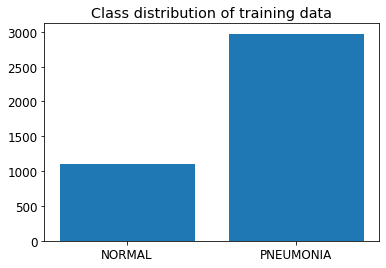

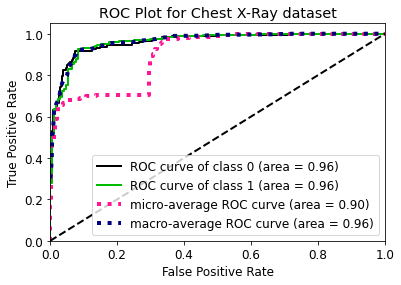

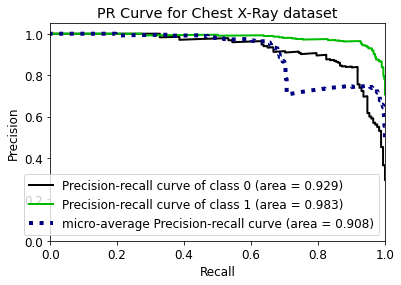

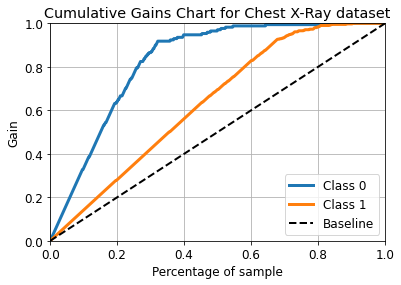

In [65]:
# !pip install scikit-plot==0.3.7
from transformers import pipeline
from sklearn import datasets, metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
import scikitplot as skplt
import pandas as pd
import warnings
from transformers.pipelines.pt_utils import KeyDataset
from sklearn.metrics import roc_curve, roc_auc_score

ds = load_dataset("keremberke/chest-xray-classification", name="full")

# Inference using the model on unseen test data
ds['test'].set_transform(preprocess_val)
predictions = trainer.predict(ds['test'])

# metrics
print("Accuracy:", predictions.metrics["test_accuracy"])
print("Precision:", predictions.metrics["test_precision"])
print("Recall:", predictions.metrics["test_recall"])
print("F1-Score:", predictions.metrics["test_f1_score"])

# Probability scores
y_probs = torch.nn.functional.softmax(torch.Tensor(predictions[0]), dim=-1) #retrieving probabilities that would be returned by self.classifier

# Ground truth
y_test = ds['test'].with_format("torch")['labels']

# Probability of the class with the greater label & predicted label ids
y_max_probs, y_preds = torch.max(y_probs,1)

##### Visualization
plt.rc('font', size=12) # controls default text sizes

print("roc_auc_score:", metrics.roc_auc_score(y_test, y_max_probs))

#visualizing class distribution of training data
plt.bar(["NORMAL", "PNEUMONIA"], [len(ds['train']['labels'])-sum(ds['train']['labels']), sum(ds['train']['labels'])])
plt.title("Class distribution of training data")

# plotting ROC curve
skplt.metrics.plot_roc(y_test, y_probs, title = 'ROC Plot for Chest X-Ray dataset')
plt.show()

#plotting precision, recall across classification thresholds
skplt.metrics.plot_precision_recall(y_test, y_probs, title = 'PR Curve for Chest X-Ray dataset')
plt.show()

#plotting cumulative gain
skplt.metrics.plot_cumulative_gain(y_test, y_probs, title = 'Cumulative Gains Chart for Chest X-Ray dataset')
plt.show()

# plotting confusion matrix
# skplt.metrics.plot_confusion_matrix(y_test, y_preds, normalize=False, title = 'Normalized Confusion Matrix for Chest X-Ray dataset')
# plt.show()
